## import

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data Load

In [3]:
# 파일 호출
data_path = "../data"
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# sub data
interestrate_df = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_df = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_df = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_df = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

## 분포 확인

In [4]:
train_df[:1000000].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   index                1000000 non-null  int64  
 1   area_m2              1000000 non-null  float64
 2   contract_year_month  1000000 non-null  int64  
 3   contract_day         1000000 non-null  int64  
 4   contract_type        1000000 non-null  int64  
 5   floor                1000000 non-null  int64  
 6   built_year           1000000 non-null  int64  
 7   latitude             1000000 non-null  float64
 8   longitude            1000000 non-null  float64
 9   age                  1000000 non-null  int64  
 10  deposit              1000000 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 83.9 MB


In [5]:
train_df[1000000:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801228 entries, 1000000 to 1801227
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                801228 non-null  int64  
 1   area_m2              801228 non-null  float64
 2   contract_year_month  801228 non-null  int64  
 3   contract_day         801228 non-null  int64  
 4   contract_type        801228 non-null  int64  
 5   floor                801228 non-null  int64  
 6   built_year           801228 non-null  int64  
 7   latitude             801228 non-null  float64
 8   longitude            801228 non-null  float64
 9   age                  801228 non-null  int64  
 10  deposit              801228 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 67.2 MB


In [6]:
pd.set_option('display.float_format', '{:.3f}'.format)
train_df.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
count,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000,1801228.000
mean,900613.500,75.188,202133.126,15.899,1.204,10.052,2004.199,37.477,126.966,17.066,38162.229
std,519969.880,25.526,135.281,8.626,0.885,6.973,11.151,0.163,0.170,11.128,26103.774
min,0.000,10.322,201904.000,1.000,0.000,-4.000,1961.000,36.918,126.479,-3.000,300.000
25%,450306.750,59.750,202008.000,9.000,0.000,5.000,1995.000,37.380,126.842,7.000,21000.000
50%,900613.500,77.150,202111.000,16.000,2.000,9.000,2004.000,37.502,126.998,17.000,32000.000
75%,1350920.250,84.960,202212.000,23.000,2.000,14.000,2015.000,37.582,127.089,26.000,47800.000
max,1801227.000,317.360,202312.000,31.000,2.000,68.000,2024.000,38.182,127.661,62.000,1100000.000


In [7]:
pd.set_option('display.float_format', '{:.3f}'.format)
train_df.corr()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
index,1.000,-0.022,0.377,0.001,-0.256,-0.010,-0.053,0.249,-0.306,0.099,0.218
area_m2,-0.022,1.000,-0.008,0.005,0.006,0.105,0.083,-0.005,0.028,-0.084,0.522
contract_year_month,0.377,-0.008,1.000,-0.024,-0.645,0.022,0.078,-0.020,0.008,0.044,0.073
contract_day,0.001,0.005,-0.024,1.000,0.020,-0.002,0.001,0.006,0.005,-0.004,0.007
contract_type,-0.256,0.006,-0.645,0.020,1.000,-0.020,-0.072,0.016,0.000,-0.006,-0.086
floor,-0.010,0.105,0.022,-0.002,-0.020,1.000,0.290,-0.032,-0.039,-0.288,0.132
built_year,-0.053,0.083,0.078,0.001,-0.072,0.290,1.000,-0.080,0.009,-0.993,0.145
latitude,0.249,-0.005,-0.020,0.006,0.016,-0.032,-0.080,1.000,-0.148,0.078,0.076
longitude,-0.306,0.028,0.008,0.005,0.000,-0.039,0.009,-0.148,1.000,-0.008,0.157
age,0.099,-0.084,0.044,-0.004,-0.006,-0.288,-0.993,0.078,-0.008,1.000,-0.136


## feature extraction

#### 날짜

In [8]:
train_df['contract_date'] = pd.to_datetime(train_df['contract_year_month'].astype(str) + train_df['contract_day'].astype(str).str.zfill(2), format='%Y%m%d')

#### interest rate

In [9]:
train_df = train_df.merge(interestrate_df[['year_month', 'interest_rate']], left_on='contract_year_month', right_on='year_month', how='left')
train_df = train_df.drop(columns=['year_month'])

test_df = test_df.merge(interestrate_df[['year_month', 'interest_rate']], left_on='contract_year_month', right_on='year_month', how='left')
test_df = test_df.drop(columns=['year_month'])

#### park, school, subway

In [10]:
places_dict = {'park':park_df, 'school':school_df, 'subway':subway_df}
radii = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]

In [11]:
elementary_school_df = school_df[school_df['schoolLevel']=='elementary']
middle_school_df = school_df[school_df['schoolLevel']=='middle']
high_school_df = school_df[school_df['schoolLevel']=='high']

In [12]:
from sklearn.neighbors import BallTree

# 위경도를 라디안으로 변환
def to_radians(df, lat_col='latitude', lon_col='longitude'):
    df['latitude_radi'] = np.radians(df[lat_col])
    df['longitude_radi'] = np.radians(df[lon_col])
    return df

In [13]:
def count_places(main_df, places_dict, radii):
    """
    main_df: 원본 데이터 (계산 대상 위치)
    places_dict: 장소 데이터 딕셔너리, {장소 이름: 장소 데이터프레임}
    radii: 반경 리스트 (예: [300, 500, 1000])
    """
    
    # 위경도를 라디안으로 변환 (main_df에 적용)
    main_df = to_radians(main_df)

    # 각 장소 유형별로 BallTree를 생성하여 반경 내 개수를 계산
    for place_name, add_df in places_dict.items():

        # 각 장소 데이터의 위경도를 라디안으로 변환
        add_df = to_radians(add_df)

        # 장소 데이터에 대해 BallTree 생성
        ball_tree = BallTree(add_df[['latitude_radi', 'longitude_radi']].values, metric='haversine')

        for radius in radii:
            # 반경을 km로 변환
            radius_in_km = radius / 1000

            # 반경 내 place 개수 계산(반경을 지구 반지름(6371km)로 나눈 값)
            _, indices = ball_tree.query_radius(main_df[['latitude_radi', 'longitude_radi']].values, r=radius_in_km/6371, return_distance=True)

            # 반경별 장소 개수 열 추가
            main_df[f'{place_name}_{radius}m'] = [len(idx) for idx in indices]
        
        distances, distances_index = ball_tree.query(main_df[['latitude_radi', 'longitude_radi']].values, k=1)
        main_df[f'{place_name}_near_distance'] = distances.flatten()*6371

        # 공원: area 추가
        if place_name == 'park':
            main_df['park_near_area'] = add_df.iloc[distances_index.flatten(), 2].reset_index(drop=True)

    return main_df

In [14]:
train_df = count_places(train_df, places_dict, radii)
test_df = count_places(test_df, places_dict, radii)

## feature selection

In [15]:
train_df = train_df.drop(columns=['index'])
test_df = test_df.drop(columns=['index'])

## train, valid split

In [16]:
holdout_start = 202307
holdout_end = 202312
valid_df = train_df[(train_df['contract_year_month'] >= holdout_start) & (train_df['contract_year_month'] <= holdout_end)]
final_train_df = train_df[~((train_df['contract_year_month'] >= holdout_start) & (train_df['contract_year_month'] <= holdout_end))]

## X, y split

In [17]:
X_train = final_train_df.drop(columns=['deposit','contract_date'])
y_train = final_train_df['deposit']
X_valid = valid_df.drop(columns=['deposit','contract_date'])
y_valid = valid_df['deposit']
X_test = test_df.copy()

X_total = train_df.drop(columns=['deposit','contract_date'])
y_total = train_df['deposit']

## 군집화

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=RANDOM_SEED)
kmeans.fit(X_total[['latitude', 'longitude']])
total_pred = kmeans.predict(X_total[['latitude', 'longitude']])

In [19]:
unique, counts = np.unique(total_pred, return_counts=True)
print(unique, counts)

[0 1 2] [473149 683599 644480]


In [20]:
def elbow_method(data, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    return inertias

In [21]:
max_clusters = 20
inertias = elbow_method(X_total[['latitude', 'longitude']], max_clusters=max_clusters)

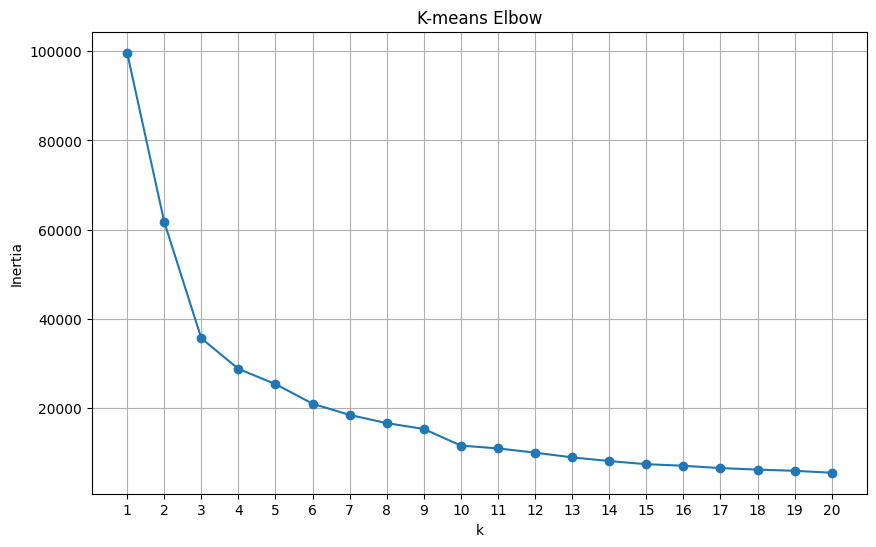

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('K-means Elbow')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [24]:
inertias_diff = np.diff(inertias)
print(inertias_diff / inertias[:max_clusters-1])   # index+1에서 index+2로 변할 때, index+1 대비 변화율

[-0.38075149 -0.42365096 -0.1929383  -0.11886381 -0.17434439 -0.12039384
 -0.10029121 -0.07919756 -0.24523669 -0.05504091 -0.08773265 -0.10694169
 -0.09306246 -0.08859114 -0.04799042 -0.07551915 -0.0518254  -0.04555747
 -0.07320349]


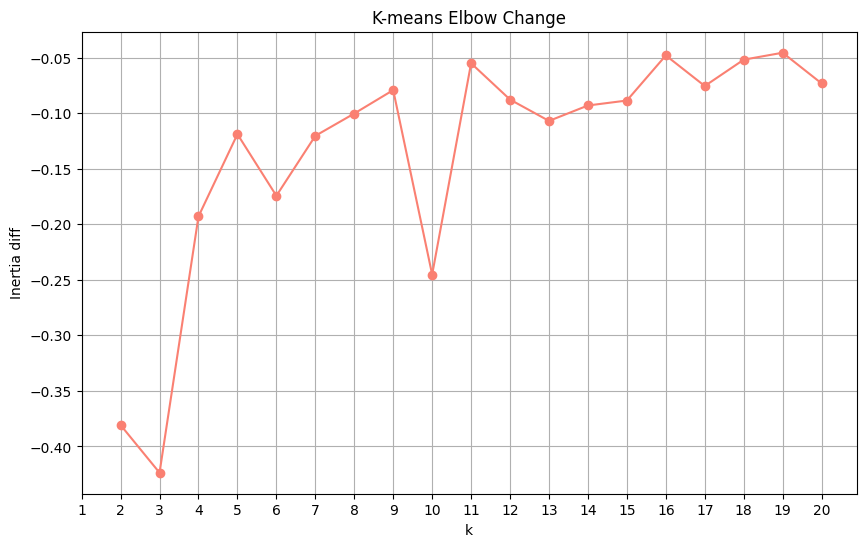

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), inertias_diff / inertias[:max_clusters-1], marker='o', c='salmon')
plt.xlabel('k')
plt.ylabel('Inertia diff')
plt.title('K-means Elbow Change')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [26]:
# train + valid 데이터로 최적의 k 찾기
best_k = 10
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_SEED)
kmeans.fit(X_total[['latitude', 'longitude']])
total_pred = kmeans.predict(X_total[['latitude', 'longitude']])

In [27]:
unique, counts = np.unique(total_pred, return_counts=True)
print(unique, counts)

[0 1 2 3 4 5 6 7 8 9] [169002 262226 152997 239963  92444 336878  75529 236496  15729 219964]


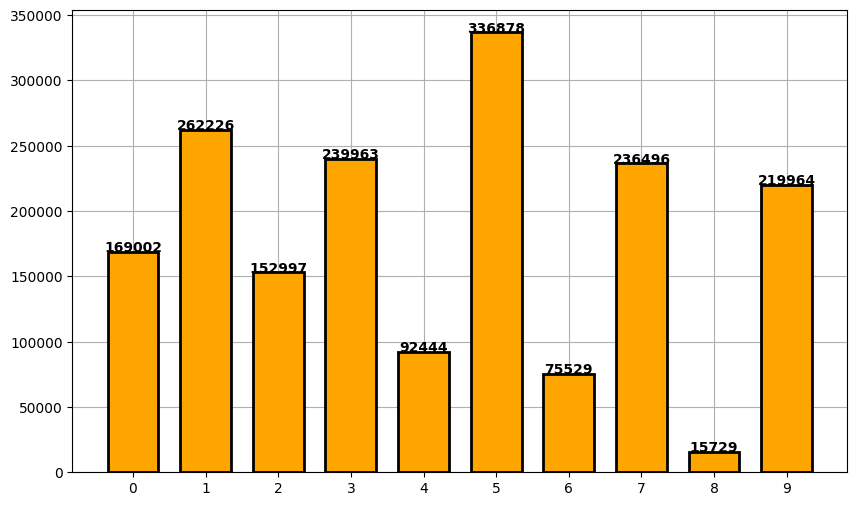

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, width=0.7, edgecolor='black', linewidth=2, color='orange', zorder=10)
plt.grid(axis='both', zorder=0)
for idx, value in zip(unique, counts):
    plt.text(idx, value, s=value,ha='center',fontweight='bold')
plt.xticks(range(0, best_k))
plt.show()

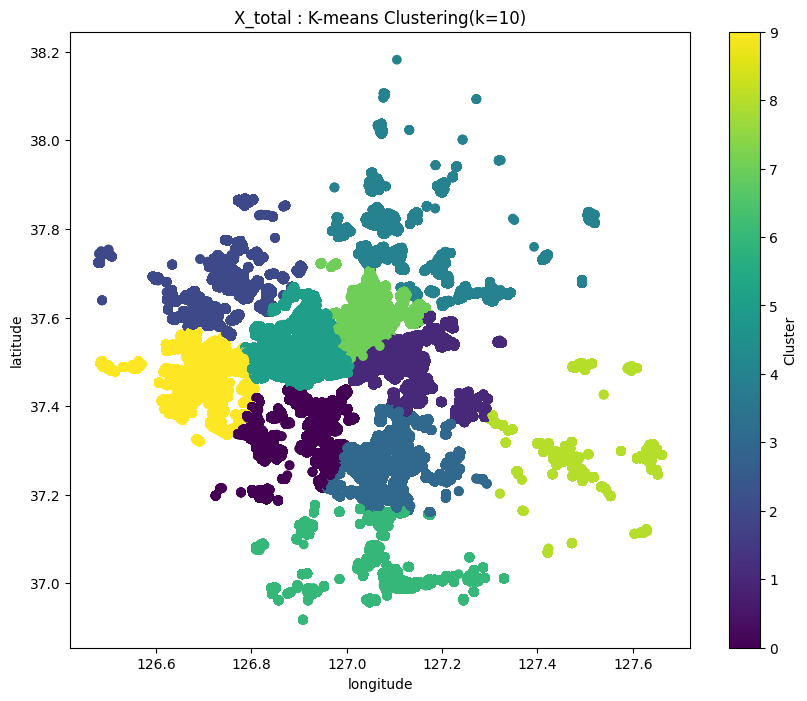

In [32]:
# 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X_total['longitude'], X_total['latitude'], c=total_pred, cmap='viridis')
plt.title(f'X_total : K-means Clustering(k={best_k})')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label='Cluster')
plt.show()

In [33]:
# test 데이터에 대한 cluster 예측
test_pred = kmeans.predict(X_test[['latitude', 'longitude']])

In [35]:
unique, counts = np.unique(test_pred, return_counts=True)
print(unique, counts)

[0 1 2 3 4 5 6 7 8 9] [14576 21188 13323 20198  8059 26730  7098 19403  1469 18128]


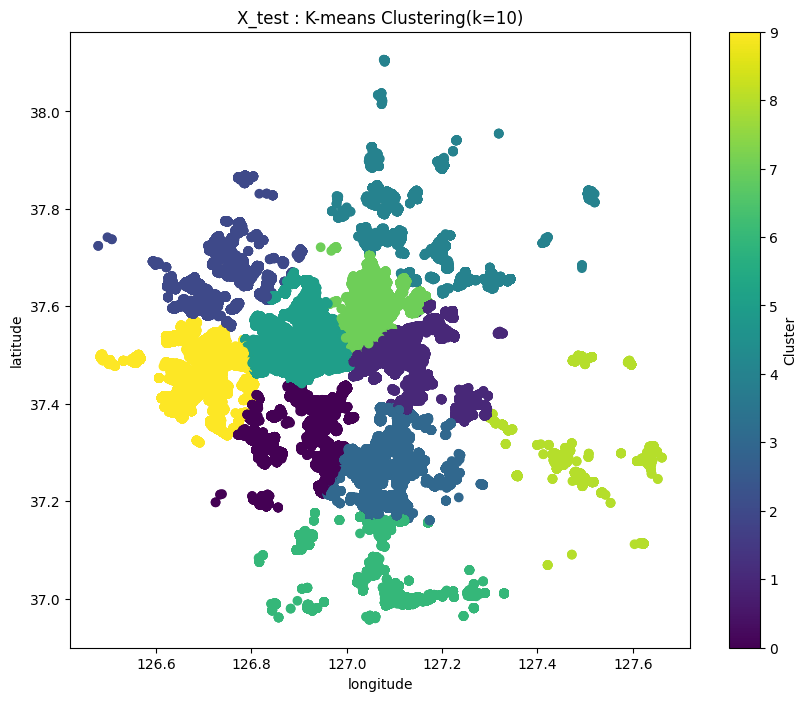

In [36]:
# 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X_test['longitude'], X_test['latitude'], c=test_pred, cmap='viridis')
plt.title(f'X_test : K-means Clustering(k={best_k})')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label='Cluster')
plt.show()

## 모델링

#### xgboost

Cluster 0 modeling...
[0]	validation_0-mae:11822.31016
[20]	validation_0-mae:8620.07443
[40]	validation_0-mae:6543.95188
[60]	validation_0-mae:5292.52781
[80]	validation_0-mae:4557.44077
[100]	validation_0-mae:4093.79323
[120]	validation_0-mae:3800.17085
[140]	validation_0-mae:3614.74065
[160]	validation_0-mae:3480.91959
[180]	validation_0-mae:3394.53693
[200]	validation_0-mae:3329.68503
[220]	validation_0-mae:3284.11400
[240]	validation_0-mae:3253.94977
[260]	validation_0-mae:3232.20679
[280]	validation_0-mae:3216.48926
[300]	validation_0-mae:3202.12797
[320]	validation_0-mae:3192.38806
[340]	validation_0-mae:3183.61158
[360]	validation_0-mae:3178.37649
[380]	validation_0-mae:3173.66550
[400]	validation_0-mae:3166.98560
[420]	validation_0-mae:3164.43865
[440]	validation_0-mae:3161.17771
[460]	validation_0-mae:3158.83831
[480]	validation_0-mae:3157.20031
[499]	validation_0-mae:3154.71205
Cluster 1 modeling...
[0]	validation_0-mae:25794.75731
[20]	validation_0-mae:19682.80823
[40]	valid

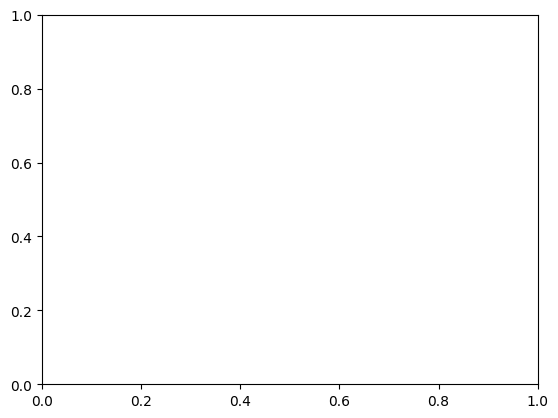

In [39]:
xgb_models = []
best_iterations = []
train_pred = kmeans.predict(X_train[['latitude', 'longitude']])
valid_pred = kmeans.predict(X_valid[['latitude', 'longitude']])

for i in range(best_k):
    print(f'Cluster {i} modeling...')
    train_cluster_idx = np.where(train_pred == i)[0]   # (index_array, dtype)
    valid_cluster_idx = np.where(valid_pred == i)[0]

    X_train_cluster = X_train.iloc[train_cluster_idx]
    y_train_cluster = y_train.iloc[train_cluster_idx]

    X_valid_cluster = X_valid.iloc[valid_cluster_idx]
    y_valid_cluster = y_valid.iloc[valid_cluster_idx]

    xgb_params = {
        'objective': 'reg:absoluteerror',   # default : reg:squarederror  # loss- train
        'eval_metric': 'mae',   # default : rmse # valid
        'seed': RANDOM_SEED,
        'n_estimators': 500,
        'learning_rate': 0.02,   # default : 0.3
        'max_depth': 12,
        # 'subsample': 0.9,
        # 'colsample_bytree': 0.9,
        # 'reg_alpha': 10.0,
        # 'reg_lambda': 10.0,
        'early_stopping_rounds':20,
        'n_jobs': -1,
    }

    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train_cluster, y_train_cluster, eval_set=[(X_valid_cluster, y_valid_cluster)], verbose=20)
    best_iterations.append(xgb_model.best_iteration)

    xgb_models.append(xgb_model)

In [40]:
best_iterations

[499, 499, 499, 499, 498, 499, 426, 499, 396, 499]

## valid 성능

In [41]:
X_valid['pred'] = 0
for i in range(best_k):
    valid_cluster_idx = np.where(valid_pred == i)[0]
    X_valid_cluster = X_valid.iloc[valid_cluster_idx]
    X_valid.loc[X_valid_cluster.index, 'pred'] = xgb_models[i].predict(X_valid_cluster.drop(columns=['pred']))

valid_pred = X_valid['pred']
valid_mae = mean_absolute_error(y_valid, valid_pred)

print(valid_mae)

/tmp/ipykernel_716800/3424352921.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[28769.71  29894.58  29222.004 ... 22290.775 29913.303 21255.06 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_valid.loc[X_valid_cluster.index, 'pred'] = xgb_models[i].predict(X_valid_cluster.drop(columns=['pred']))


4456.724993400865


## 최종 학습

Cluster 0 modeling...
Cluster 1 modeling...
Cluster 2 modeling...
Cluster 3 modeling...
Cluster 4 modeling...
Cluster 5 modeling...
Cluster 6 modeling...
Cluster 7 modeling...
Cluster 8 modeling...
Cluster 9 modeling...


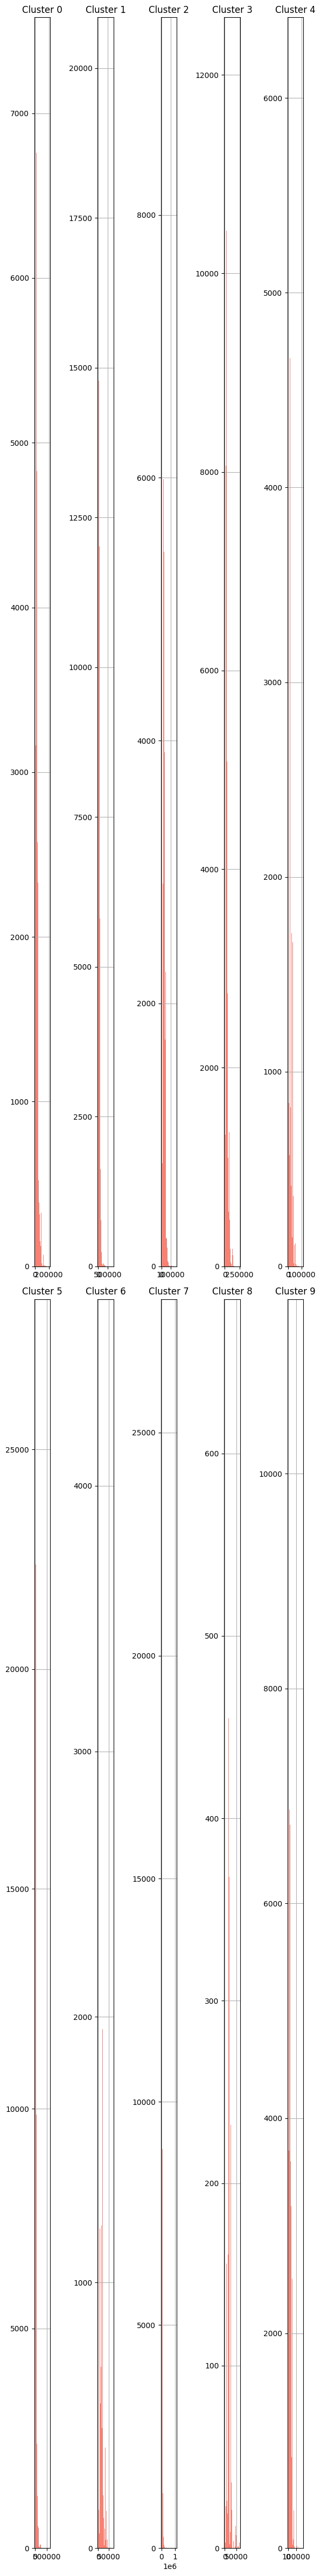

In [76]:
xgb_models = []
total_pred = kmeans.predict(X_total[['latitude', 'longitude']])

n_cols = 5
n_rows = (best_k + 1) // n_cols

plt.figure(figsize=(6, 24 * n_rows))

for i in range(best_k):
    print(f'Cluster {i} modeling...')
    total_cluster_idx = np.where(total_pred == i)[0]   # (index_array, dtype)

    X_total_cluster = X_total.iloc[total_cluster_idx]
    y_total_cluster = y_total.iloc[total_cluster_idx]

    xgb_params = {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mape',
        'seed': RANDOM_SEED,
        'n_estimators': round(best_iterations[i], -1),   # 1의 자리에서 반올림
        'learning_rate': 0.02,   # default : 0.3
        'max_depth': 12,
        # 'subsample': 0.9,
        # 'colsample_bytree': 0.9,
        # 'reg_alpha': 10.0,
        # 'reg_lambda': 10.0,
        # 'early_stopping_rounds':20,
        'n_jobs': -1,
    }

    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_total_cluster, y_total_cluster, verbose=20)

    xgb_models.append(xgb_model)

    # 시각화
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(y_total_cluster, bins=200, color='salmon')
    plt.title(f'Cluster {i}')
    plt.grid(True)

plt.tight_layout()
plt.show()

## submit

In [39]:
X_test['pred'] = 0
for i in range(best_k):
    test_cluster_idx = np.where(test_pred == i)[0]
    X_test_cluster = X_test.iloc[test_cluster_idx]
    X_test.loc[X_test_cluster.index, 'pred'] = xgb_models[i].predict(X_test_cluster.drop(columns=['pred']))

test_pred_xgb_cluster = X_test['pred']

/tmp/ipykernel_702226/2610770736.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25262.734 33048.668 23397.676 ... 32129.162 32129.162 31923.617]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[X_test_cluster.index, 'pred'] = xgb_models[i].predict(X_test_cluster.drop(columns=['pred']))


In [41]:
sample_submission['deposit'] = test_pred_xgb_cluster
sample_submission.to_csv('1013_2_clu.csv', index=False, encoding='utf-8-sig')

0        22981.422
1         7902.604
2         6963.983
3         6981.022
4         6814.571
            ...   
150167   36472.613
150168   38657.238
150169   39072.965
150170   35312.805
150171   35870.125
Name: pred, Length: 150172, dtype: float64

In [131]:
print(y_total.min(), y_total.max())
print(test_pred_xgb_cluster.min(), test_pred_xgb_cluster.max())

300.0 1100000.0
1985.9237060546875 727360.625
